In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, models
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from tqdm import tqdm
import os
from sklearn.metrics import accuracy_score
import timm
from tqdm import tqdm  
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR

if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available

/Users/georgia.bucea/practice_programming/practice_ai/Kaggle/Dog_Breed_Identification/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_in = 'dog-breed-identification' #Folder with input (image, lable)
root_out = 'dog-breed-identification/Output' #Folder with output image 

In [3]:
class_to_index={'boston_bull': 0,
 'dingo': 1,
 'pekinese': 2,
 'bluetick': 3,
 'golden_retriever': 4,
 'bedlington_terrier': 5,
 'borzoi': 6,
 'basenji': 7,
 'scottish_deerhound': 8,
 'shetland_sheepdog': 9,
 'walker_hound': 10,
 'maltese_dog': 11,
 'norfolk_terrier': 12,
 'african_hunting_dog': 13,
 'wire-haired_fox_terrier': 14,
 'redbone': 15,
 'lakeland_terrier': 16,
 'boxer': 17,
 'doberman': 18,
 'otterhound': 19,
 'standard_schnauzer': 20,
 'irish_water_spaniel': 21,
 'black-and-tan_coonhound': 22,
 'cairn': 23,
 'affenpinscher': 24,
 'labrador_retriever': 25,
 'ibizan_hound': 26,
 'english_setter': 27,
 'weimaraner': 28,
 'giant_schnauzer': 29,
 'groenendael': 30,
 'dhole': 31,
 'toy_poodle': 32,
 'border_terrier': 33,
 'tibetan_terrier': 34,
 'norwegian_elkhound': 35,
 'shih-tzu': 36,
 'irish_terrier': 37,
 'kuvasz': 38,
 'german_shepherd': 39,
 'greater_swiss_mountain_dog': 40,
 'basset': 41,
 'australian_terrier': 42,
 'schipperke': 43,
 'rhodesian_ridgeback': 44,
 'irish_setter': 45,
 'appenzeller': 46,
 'bloodhound': 47,
 'samoyed': 48,
 'miniature_schnauzer': 49,
 'brittany_spaniel': 50,
 'kelpie': 51,
 'papillon': 52,
 'border_collie': 53,
 'entlebucher': 54,
 'collie': 55,
 'malamute': 56,
 'welsh_springer_spaniel': 57,
 'chihuahua': 58,
 'saluki': 59,
 'pug': 60,
 'malinois': 61,
 'komondor': 62,
 'airedale': 63,
 'leonberg': 64,
 'mexican_hairless': 65,
 'bull_mastiff': 66,
 'bernese_mountain_dog': 67,
 'american_staffordshire_terrier': 68,
 'lhasa': 69,
 'cardigan': 70,
 'italian_greyhound': 71,
 'clumber': 72,
 'scotch_terrier': 73,
 'afghan_hound': 74,
 'old_english_sheepdog': 75,
 'saint_bernard': 76,
 'miniature_pinscher': 77,
 'eskimo_dog': 78,
 'irish_wolfhound': 79,
 'brabancon_griffon': 80,
 'toy_terrier': 81,
 'chow': 82,
 'flat-coated_retriever': 83,
 'norwich_terrier': 84,
 'soft-coated_wheaten_terrier': 85,
 'staffordshire_bullterrier': 86,
 'english_foxhound': 87,
 'gordon_setter': 88,
 'siberian_husky': 89,
 'newfoundland': 90,
 'briard': 91,
 'chesapeake_bay_retriever': 92,
 'dandie_dinmont': 93,
 'great_pyrenees': 94,
 'beagle': 95,
 'vizsla': 96,
 'west_highland_white_terrier': 97,
 'kerry_blue_terrier': 98,
 'whippet': 99,
 'sealyham_terrier': 100,
 'standard_poodle': 101,
 'keeshond': 102,
 'japanese_spaniel': 103,
 'miniature_poodle': 104,
 'pomeranian': 105,
 'curly-coated_retriever': 106,
 'yorkshire_terrier': 107,
 'pembroke': 108,
 'great_dane': 109,
 'blenheim_spaniel': 110,
 'silky_terrier': 111,
 'sussex_spaniel': 112,
 'german_short-haired_pointer': 113,
 'french_bulldog': 114,
 'bouvier_des_flandres': 115,
 'tibetan_mastiff': 116,
 'english_springer': 117,
 'cocker_spaniel': 118,
 'rottweiler': 119}

In [4]:
class Dogs_Train_Dataset(Dataset):
    '''Train Dataset'''
    def __init__(self, file_in, transform=None):
        self.img_paths = pd.read_csv(file_in)
        self.transform = transform
        self.classes, self.class_to_idx = class_to_index.keys,class_to_index
        
    def __len__(self):
        return self.img_paths.shape[0]
    
    def __getitem__(self, index):
        img = Image.open(os.path.join(root_in, 'train', self.img_paths.iloc[index, 0] + '.jpg'))
        label_index = self.class_to_idx[self.img_paths.iloc[index, 1]]
        if self.transform:
            img = self.transform(img)
        return img, label_index

In [5]:
class Dogs_Test_Dataset(Dogs_Train_Dataset):
    '''Test Dataset'''
    def __getitem__(self, index):
        img = Image.open(os.path.join(root_in, 'test', self.img_paths.iloc[index, 1] + '.jpg'))
        if self.transform:
            img = self.transform(img)
        return img

In [8]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),

    transforms.RandomResizedCrop(224, scale=(0.2, 1.0), ratio=(3.0 / 4.0, 4.0 / 3.0)),
    transforms.RandomHorizontalFlip(),
    
    #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),
    
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])


dog_train_dataset = Dogs_Train_Dataset(os.path.join(root_in, 'labels.csv'),transform=train_transform)
dog_val_dataset = Dogs_Train_Dataset(os.path.join(root_in, 'labels.csv'),transform=val_test_transform)


dog_test_dataset= Dogs_Test_Dataset(os.path.join(root_out, 'test.csv'),transform=val_test_transform)


# img, label = next(iter(dog_train_loader))

# print( label)

In [9]:
train_length = int(len(dog_train_dataset) * 0.90) # train_length is not used

valid_length = len(dog_train_dataset) - train_length # define the valid_dataset's length
_, dog_val_dataset = random_split(dog_val_dataset, [train_length, valid_length])

In [21]:
dog_train_loader = DataLoader(dog_train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=0)
dog_val_loader = DataLoader(dog_val_dataset, batch_size=64, shuffle=True, num_workers=0)
dog_test_loader = DataLoader(dog_test_dataset, batch_size=64, shuffle=False, num_workers=0)

In [22]:
import random
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        title=""
        if classes:
            title = f"class: {classes[targ_label]}"
        if display_shape:
            title = title + f"\nshape: {targ_image_adjust.shape}"
            plt.title(title)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.1461596].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7754089..2.622571].
Cl

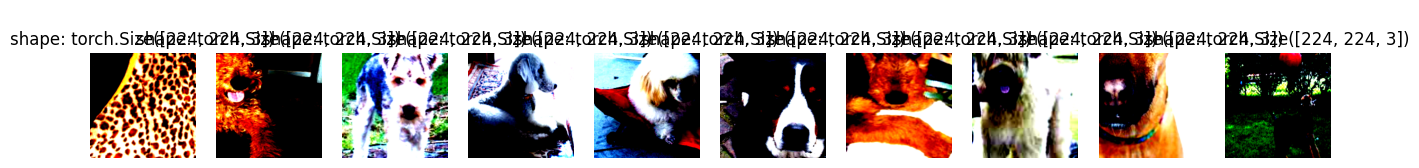

In [12]:
display_random_images(dog_train_dataset,None,10,True)

In [13]:
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [20]:
summary(model=model, 
        input_size=(64, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=40,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape                              Output Shape                             Param #                                  Trainable
EfficientNet (EfficientNet)                                  [64, 3, 224, 224]                        [64, 120]                                --                                       Partial
├─Sequential (features)                                      [64, 3, 224, 224]                        [64, 1280, 7, 7]                         --                                       False
│    └─Conv2dNormActivation (0)                              [64, 3, 224, 224]                        [64, 32, 112, 112]                       --                                       False
│    │    └─Conv2d (0)                                       [64, 3, 224, 224]                        [64, 32, 112, 112]                       (864)                                    False
│    │    └─BatchNorm2d (1)                 

In [23]:
for param in model.features.parameters():
    param.requires_grad = False

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_to_index.keys())

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print("[INFO] Couldn't find tensorboard... installing it.")
    !pip install -q tensorboard
    from torch.utils.tensorboard import SummaryWriter


# Create a writer with all default settings
writer = SummaryWriter()

In [35]:
from typing import Dict, List
from tqdm.auto import tqdm

from engine import train_step, test_step

# Import train() function from: 
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(64, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [40]:
import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=model,
                train_dataloader=dog_train_loader,
                test_dataloader=dog_val_loader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=30,
                device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9721 | train_acc: 0.7862 | test_loss: 0.9339 | test_acc: 0.7654


  3%|▎         | 1/30 [01:04<30:57, 64.06s/it]

Epoch: 2 | train_loss: 1.0901 | train_acc: 0.7362 | test_loss: 0.8422 | test_acc: 0.7732


  7%|▋         | 2/30 [02:14<31:33, 67.62s/it]

Epoch: 3 | train_loss: 1.0658 | train_acc: 0.7380 | test_loss: 0.8287 | test_acc: 0.7712


 10%|█         | 3/30 [03:18<29:49, 66.28s/it]

Epoch: 4 | train_loss: 1.0269 | train_acc: 0.7480 | test_loss: 0.8130 | test_acc: 0.7791


 13%|█▎        | 4/30 [04:23<28:28, 65.70s/it]

Epoch: 5 | train_loss: 1.0162 | train_acc: 0.7506 | test_loss: 0.7725 | test_acc: 0.7898


 17%|█▋        | 5/30 [05:23<26:30, 63.61s/it]

Epoch: 6 | train_loss: 1.1465 | train_acc: 0.6989 | test_loss: 0.7797 | test_acc: 0.7781


 20%|██        | 6/30 [06:43<27:42, 69.27s/it]

Epoch: 7 | train_loss: 1.1287 | train_acc: 0.7063 | test_loss: 0.7072 | test_acc: 0.8104


 23%|██▎       | 7/30 [07:42<25:16, 65.93s/it]

Epoch: 8 | train_loss: 1.0836 | train_acc: 0.7147 | test_loss: 0.7082 | test_acc: 0.7947


 27%|██▋       | 8/30 [08:42<23:27, 63.96s/it]

Epoch: 9 | train_loss: 1.0773 | train_acc: 0.7114 | test_loss: 0.6694 | test_acc: 0.8083


 30%|███       | 9/30 [09:38<21:26, 61.28s/it]

Epoch: 10 | train_loss: 1.0593 | train_acc: 0.7169 | test_loss: 0.6738 | test_acc: 0.8172


 33%|███▎      | 10/30 [10:40<20:32, 61.64s/it]

Epoch: 11 | train_loss: 1.0267 | train_acc: 0.7301 | test_loss: 0.6862 | test_acc: 0.8192


 37%|███▋      | 11/30 [11:49<20:11, 63.78s/it]

Epoch: 12 | train_loss: 1.0045 | train_acc: 0.7322 | test_loss: 0.6479 | test_acc: 0.8231


 40%|████      | 12/30 [12:51<19:02, 63.46s/it]

Epoch: 13 | train_loss: 0.9949 | train_acc: 0.7297 | test_loss: 0.6747 | test_acc: 0.8211


 43%|████▎     | 13/30 [13:51<17:37, 62.20s/it]

Epoch: 14 | train_loss: 0.9977 | train_acc: 0.7322 | test_loss: 0.6569 | test_acc: 0.8230


 47%|████▋     | 14/30 [14:51<16:25, 61.59s/it]

Epoch: 15 | train_loss: 0.9604 | train_acc: 0.7403 | test_loss: 0.6198 | test_acc: 0.8358


 50%|█████     | 15/30 [15:48<15:04, 60.28s/it]

Epoch: 16 | train_loss: 0.9669 | train_acc: 0.7373 | test_loss: 0.6096 | test_acc: 0.8387


 53%|█████▎    | 16/30 [16:44<13:45, 58.94s/it]

Epoch: 17 | train_loss: 0.9537 | train_acc: 0.7426 | test_loss: 0.5826 | test_acc: 0.8416


 57%|█████▋    | 17/30 [17:43<12:46, 58.99s/it]

Epoch: 18 | train_loss: 0.9380 | train_acc: 0.7507 | test_loss: 0.5981 | test_acc: 0.8388


 60%|██████    | 18/30 [18:43<11:51, 59.28s/it]

Epoch: 19 | train_loss: 0.9361 | train_acc: 0.7477 | test_loss: 0.5855 | test_acc: 0.8426


 63%|██████▎   | 19/30 [19:45<11:00, 60.06s/it]

Epoch: 20 | train_loss: 0.9246 | train_acc: 0.7453 | test_loss: 0.6402 | test_acc: 0.8348


 67%|██████▋   | 20/30 [21:08<11:10, 67.04s/it]

Epoch: 21 | train_loss: 0.9064 | train_acc: 0.7517 | test_loss: 0.5929 | test_acc: 0.8465


 70%|███████   | 21/30 [22:08<09:45, 65.02s/it]

Epoch: 22 | train_loss: 0.9042 | train_acc: 0.7536 | test_loss: 0.5979 | test_acc: 0.8299


 73%|███████▎  | 22/30 [23:05<08:20, 62.62s/it]

Epoch: 23 | train_loss: 0.8908 | train_acc: 0.7565 | test_loss: 0.5914 | test_acc: 0.8446


 77%|███████▋  | 23/30 [24:01<07:03, 60.44s/it]

Epoch: 24 | train_loss: 0.8877 | train_acc: 0.7564 | test_loss: 0.6073 | test_acc: 0.8348


 80%|████████  | 24/30 [24:57<05:55, 59.19s/it]

Epoch: 25 | train_loss: 0.8814 | train_acc: 0.7577 | test_loss: 0.5845 | test_acc: 0.8456


 83%|████████▎ | 25/30 [25:56<04:55, 59.14s/it]

Epoch: 26 | train_loss: 0.8788 | train_acc: 0.7583 | test_loss: 0.5946 | test_acc: 0.8485


 87%|████████▋ | 26/30 [26:53<03:54, 58.58s/it]

Epoch: 27 | train_loss: 0.8613 | train_acc: 0.7603 | test_loss: 0.5989 | test_acc: 0.8378


 90%|█████████ | 27/30 [27:51<02:54, 58.30s/it]

Epoch: 28 | train_loss: 0.8690 | train_acc: 0.7669 | test_loss: 0.5508 | test_acc: 0.8543


 93%|█████████▎| 28/30 [28:50<01:56, 58.48s/it]

Epoch: 29 | train_loss: 0.8487 | train_acc: 0.7649 | test_loss: 0.5678 | test_acc: 0.8426


 97%|█████████▋| 29/30 [29:48<00:58, 58.36s/it]

Epoch: 30 | train_loss: 0.8534 | train_acc: 0.7617 | test_loss: 0.5945 | test_acc: 0.8407


100%|██████████| 30/30 [31:02<00:00, 62.09s/it]

[INFO] Total training time: 1862.716 seconds


In [41]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 90444), started 1:23:08 ago. (Use '!kill 90444' to kill it.)